In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
original_dim = 128
beta = 0.2
batch_size = 200
latent_dim = 4
epochs = 100

learning_rate = 1e-3
gamma = 0.1

num_traversals = 11

device='cpu'

CSV_DATA_PATH='/workspace/outputs/profiles-v2/sample-5000/profiles_v2_experiment_5_20250401_0537/20250401-dataset.csv'

In [2]:
import math
import numpy as np
import pandas as pd
import csv
import keras
import tensorflow
from keras import backend as K
from keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor

import os
import pickle
import datetime

from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from utils import (
    LoadTemperatureDataV2
)
from tqdm import tqdm

def periodic_padding(array, pad):
    N = len(array)
    M = N + 2*pad
    output = np.zeros(M)
    for index in range(pad, N+pad):
        output[index] = array[index - pad]
    for index in range(0, pad):
        output[index] = array[index + N - pad]
        output[index + N + pad] = array[index]
    return output

def pad_data(x_data):
    print("Size of x_raw: ", x_data.shape)

    if x_data.shape[1] == 128:
        x_padded = x_data

    elif x_data.shape[1] == 120:
        x_padded = []
        for xx in tqdm(x_data, desc="Applying periodic padding"):
            xx = periodic_padding(xx, 4)
            x_padded.append(xx.astype('float32'))
        x_padded = np.asarray(x_padded)

    else:
        raise ValueError(f"Unexpected input shape: {x_data.shape}")

    print("Size of x_padded: ", x_padded.shape)
    return x_padded


# Since Keras apparently does not have a built-in Exponential LR Scheduler
def lr_scheduler(epoch, lr): 
    return learning_rate * gamma**epoch
    
# * * * * * * * * * * * * * * * *
# Create Model Directory
# * * * * * * * * * * * * * * * *
# store: autoencoder, encoder, decoder, training data, profiles, latent variables
#timestamp = datetime.datetime.now().strftime("%Y%m%d")
#os.mkdir("/u/paige/asinha/projectdir/model" + timestamp + "/")

2025-07-31 01:45:22.007745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 01:45:22.129375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-07-31 01:45:22.129385: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-07-31 01:45:22.749927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7:

In [3]:
# * * * * * * * * * * * * * * * *
#  Load Data
# * * * * * * * * * * * * * * * *
data = LoadTemperatureDataV2(CSV_DATA_PATH, device)
data = data.cpu().numpy()
x_raw, x_test = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)

Loading Profiles: 142568it [00:10, 13139.91it/s]


In [4]:
# * * * * * * * * * * * * * * * *
#  Pad (1, 120) -> (1, 128)
# * * * * * * * * * * * * * * * *
x_train = pad_data(x_raw)

Size of x_raw:  (128311, 120)


Applying periodic padding: 100%|██████████| 128311/128311 [00:04<00:00, 30548.34it/s]

Size of x_padded:  (128311, 128)


In [5]:
# * * * * * * * * * * * * * * * *
# Sampling Function
# * * * * * * * * * * * * * * * *
class Sampling(layers.Layer):
    """ uses (z_mean, z_log_var) to sample z, the vector encoding an input array """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# * * * * * * * * * * * * * * * *
# VAE Definition
# * * * * * * * * * * * * * * * *
encoder_inputs = keras.Input(shape = (original_dim,))
x = tf.reshape(encoder_inputs, [-1, original_dim, 1])
x = layers.BatchNormalization()(x)
x = layers.Conv1D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu", name = "3e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "4e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "5e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "6e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "7e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "8e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "9e")(x)
x = layers.Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "10e")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(units = latent_dim, activation = None, name = "z_mean")(x)
z_log_var = layers.Dense(units = latent_dim, activation = None, name = "z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
z = tf.reshape(z, [-1, 1, 4])
encoder = tf.keras.Model(inputs = encoder_inputs, outputs = z, name = "encoder")
encoder.summary()

latent_inputs = keras.Input(shape = (1, latent_dim))
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "1d")(latent_inputs)
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "2d")(x)
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "3d")(x)
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "4d")(x)
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "5d")(x)
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "6d")(x)
x = layers.Conv1DTranspose(filters = 32, kernel_size = 2, strides = 2, padding = "same", activation = "relu", name = "7d")(x)
outputs = layers.Conv1D(filters = 1, kernel_size = 1, strides = 1, padding = "same", activation = "relu", name = "8d")(x)
decoder = tf.keras.Model(inputs = latent_inputs, outputs = outputs, name = "decoder")
decoder.summary()

outputs = decoder(z)
autoencoder = tf.keras.Model(encoder_inputs, outputs)
# add KL divergence regularization loss
D_KL = beta * -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
autoencoder.add_loss(D_KL)
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
autoencoder.compile(optimizer, loss = tf.keras.losses.MeanSquaredError())

#scaler = MinMaxScaler()
scaler = StandardScaler()

x_norm = scaler.fit_transform(x_train)


2025-07-31 01:45:41.685107: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-07-31 01:45:41.685470: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-07-31 01:45:41.685496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2025-07-31 01:45:41.686504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 128, 1)       0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 1)      4           ['tf.reshape[0][0]']             
 alization)                                                                                       
                                                                                                  
 3e (Conv1D)                    (None, 128, 32)      128         ['batch_normalization[0][0]

In [6]:

# * * * * * * * * * * * * * * * *
# Add scheduler
# * * * * * * * * * * * * * * * *
lr_callback = LearningRateScheduler(lr_scheduler)

# * * * * * * * * * * * * * * * *
# Train
# * * * * * * * * * * * * * * * *
x_vae = autoencoder.fit(
    x_norm, x_norm,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    shuffle=True,
    callbacks=[lr_callback]
)

#autoencoder.save('VAE-' + str(epochs) + 'e') ## CHANGE SAVED MODEL
#decoder.save('Decoder-' + str(epochs) + 'e') ## CHANGE SAVED MODEL
#encoder.save('Encoder-' + str(epochs) + 'e') ## CHANGE SAVED MODEL


Epoch 1/100
578/578 [==============================] - 12s 16ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 0.0010
Epoch 2/100
578/578 [==============================] - 9s 15ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-04
Epoch 3/100
578/578 [==============================] - 9s 16ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-05
Epoch 4/100
578/578 [==============================] - 9s 15ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-06
Epoch 5/100
578/578 [==============================] - 9s 15ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-07
Epoch 6/100
578/578 [==============================] - 9s 15ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-08
Epoch 7/100
578/578 [==============================] - 9s 15ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-09
Epoch 8/100
578/578 [==============================] - 9s 15ms/step - loss: 0.9993 - val_loss: 1.0064 - lr: 1.0000e-10
Epoch 9/100
578/578 [==============================

In [7]:
# * * * * * * * * * * * * * * * *
# Loss to Kelvins
# * * * * * * * * * * * * * * * *
loss_normalized = min(x_vae.history['val_loss'])  
std_test = np.std(x_train)

print(f"Best Validation Loss: {loss_normalized * std_test} K")

Best Validation Loss: 97.70877327610742 K


In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
x_test_padded = pad_data(x_test)
x_test_norm = scaler.transform(x_test_padded)

X = [0.1*jj - 0.05 for jj in range(1, len(x_test_norm)+1)]
x_fit = np.linspace(0, 24, 121)
x_fit = x_fit[0:-1] # removed hour 24 = hour 0 (added later with padding)
predictions = autoencoder.predict(x_test_norm)
transformed = np.squeeze(predictions, axis = 2)
x_hat = scaler.inverse_transform(transformed)

z_Sample = []
for ix, xx in tqdm(enumerate(x_test_norm), total=len(x_test_norm)):
    #fig = plt.figure(figsize = (5,5))
    #plt.plot(x_fit, xx[4:124], label = "GPR")
    #x_predict = x_hat[ix]
    #plt.plot(x_fit, x_predict[4:124], label = "VAE")
    #plt.legend()
    #plt.ylim(0,400)
    #plt.xlim(0,25)
    #fig.savefig('x_test_row' + str(ix) + '.png')
    #plt.close()
    z = encoder.predict(x_test_norm[ix:ix+1], verbose=0)
    z_Sample.append(z)

z_arrays = [z[0][0] for z in z_Sample]

#model_dict = {'autoencoder': [autoencoder],
#              'encoder': [encoder],
#              'decoder': [decoder],
#              'x_train': [x_train],
#              'scaler': ['MinMaxScaler()'],
#              'x_hat': [x_hat],
#              'latent_space': [z_arrays]
#}


Size of x_raw:  (14257, 120)


Applying periodic padding: 100%|██████████| 14257/14257 [00:00<00:00, 28730.99it/s]


Size of x_padded:  (14257, 128)
446/446 [==============================] - 2s 4ms/step


100%|██████████| 14257/14257 [10:07<00:00, 23.45it/s]


In [9]:
# * * * * * * * * * * * * * * * *
# Latent Var Mean
# * * * * * * * * * * * * * * * *
print("Mean latent values:")
print("z0: " + str(np.mean(z_arrays[0])))
print("z1: " + str(np.mean(z_arrays[1])))
print("z2: " + str(np.mean(z_arrays[2])))
print("z3: " + str(np.mean(z_arrays[3])))

Mean latent values:
z0: 0.57931256
z1: -0.0649848
z2: 0.043022722
z3: 0.5076075


1/1 [==============================] - 0s 16ms/step


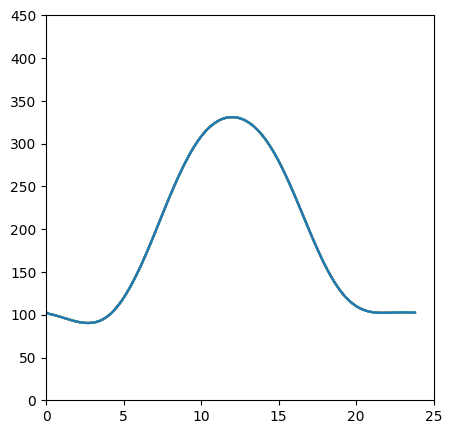

1/1 [==============================] - 0s 15ms/step


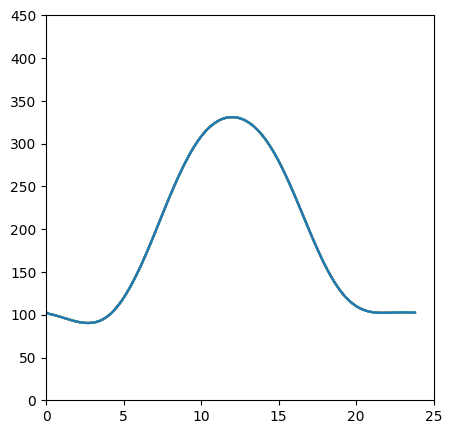

1/1 [==============================] - 0s 17ms/step


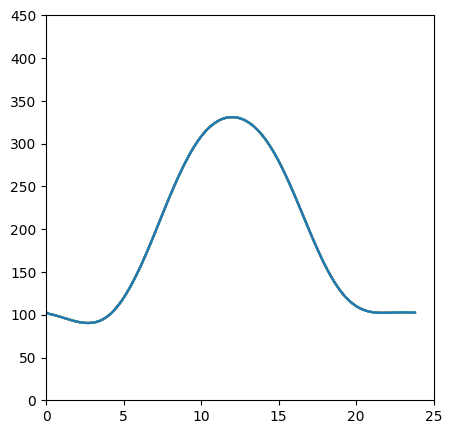

1/1 [==============================] - 0s 16ms/step


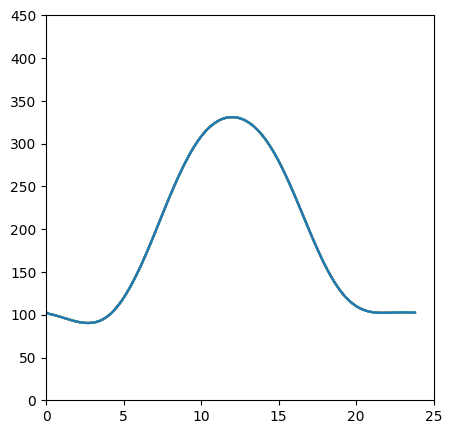

In [10]:
# * * * * * * * * * * * * * * * *
# Latent Var Visualization
# * * * * * * * * * * * * * * * *
fig = plt.figure(figsize = (5, 5))
vals = np.linspace(min(z_arrays[0]), max(z_arrays[0]), num_traversals)
#vals = [0.5, 1, 1.5, 2]
vals = np.array(vals)
for iv, val in enumerate(vals):
    z = np.array([[[val, 0, 0, 0]]])
    prediction = decoder.predict(z)
    prediction[0].transpose()
    prediction = prediction.reshape(1, -1)
    prediction = scaler.inverse_transform(prediction)
    plt.plot(x_fit, prediction[0][4:124], label="z0")
    plt.ylim(0,450)
    plt.xlim(0,25)
#fig.legend()
plt.show()
#fig.savefig("z0_exercise" + str(epochs) + ".jpg") ## ADD SUFFIX

fig = plt.figure(figsize = (5, 5))
vals = np.linspace(min(z_arrays[1]), max(z_arrays[1]), num_traversals)
#vals = [-0.5, -1, -1.5, -2, -2.5]
vals = np.array(vals)
for iv, val in enumerate(vals):
    z = np.array([[[0, val, 0, 0]]])
    prediction = decoder.predict(z)
    prediction[0].transpose()
    prediction = prediction.reshape(1, -1)
    prediction = scaler.inverse_transform(prediction)
    plt.plot(x_fit, prediction[0][4:124], label="z1")
    plt.ylim(0,450)
    plt.xlim(0,25)
#fig.legend()
plt.show()
#fig.savefig("z1_exercise" + str(epochs) + ".jpg") ## ADD SUFFIX

fig = plt.figure(figsize = (5, 5))
vals = np.linspace(min(z_arrays[2]), max(z_arrays[2]), num_traversals)
#vals = [-1, -1.5, -2, -2.5]
vals = np.array(vals)
for iv, val in enumerate(vals):
    z = np.array([[[0, 0, val, 0]]])
    prediction = decoder.predict(z)
    prediction[0].transpose()
    prediction = prediction.reshape(1, -1)
    prediction = scaler.inverse_transform(prediction)
    plt.plot(x_fit, prediction[0][4:124], label="z2")
    plt.ylim(0,450)
    plt.xlim(0,25)
#fig.legend()
plt.show()
#fig.savefig("z2_exercise" + str(epochs) + ".jpg") ## ADD SUFFIX

fig = plt.figure(figsize = (5, 5))
vals = np.linspace(min(z_arrays[3]), max(z_arrays[3]), num_traversals)
#vals = [0, -0.5, -1, -1.5, -2, -2.5]
vals = np.array(vals)
for iv, val in enumerate(vals):
    z = np.array([[[0, 0, 0, val]]])
    prediction = decoder.predict(z)
    prediction[0].transpose()
    prediction = prediction.reshape(1, -1)
    prediction = scaler.inverse_transform(prediction)
    plt.plot(x_fit, prediction[0][4:124], label="z3")
    plt.ylim(0,450)
    plt.xlim(0,25)
#fig.legend()
plt.show()
#fig.savefig("z3_exercise" + str(epochs) + ".jpg") ## ADD SUFFIX

#os.chdir("/u/paige/asinha/projectdir/pickle_folder/")
#with open(f'Model_{epochs}e_{timestamp}.pickle', 'wb'):
#    pickle.dump(model_dict, file, protocol = pickle.HIGHEST_PROTOCOL)
